#Importar librerías


In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time
import pickle

#Cargar base de datos

Habilitar uso de archivos desde drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Cargar datos sin outliers

In [0]:
ruta_base='gdrive/My Drive/Inteligencia Computacional/Proyecto/BaseDatos'

In [0]:
with open(ruta_base + '/dateR.obj','rb') as input:
  dateR=pickle.load(input)
    
with open(ruta_base + '/dateB.obj','rb') as input:
  dateB=pickle.load(input)
  
with open(ruta_base + '/MagR.obj','rb') as input:
  MagR=pickle.load(input)
  
with open(ruta_base + '/MagB.obj','rb') as input:
  MagB=pickle.load(input)
  
with open(ruta_base + '/ErMagR.obj','rb') as input:
  ErMagR=pickle.load(input)
  
with open(ruta_base + '/ErMagB.obj','rb') as input:
  ErMagB=pickle.load(input)
  
with open(ruta_base + '/Periodo.obj','rb') as input:
  Periodo=pickle.load(input)
  
with open(ruta_base + '/Nombres.obj','rb') as input:
  Nombres=pickle.load(input)
  
#with open(ruta_base + '/ErrMR.obj','rb') as input:
#  ErrMR=pickle.load(input)

#with open(ruta_base + '/ErrMB.obj','rb') as input:
#  ErrMB=pickle.load(input)
  
#with open(ruta_base + '/MR.obj','rb') as input:
#  MR=pickle.load(input)
  
#with open(ruta_base + '/MB.obj','rb') as input:
#  MB=pickle.load(input)
  
#with open(ruta_base + '/XR.obj','rb') as input:
#  XR=pickle.load(input)
  
#with open(ruta_base + '/YR.obj','rb') as input:
#  YR=pickle.load(input)
  
#with open(ruta_base + '/XB.obj','rb') as input:
#  XB=pickle.load(input)
  
#with open(ruta_base + '/YB.obj','rb') as input:
#  YB=pickle.load(input)
  
#with open(ruta_base + '/ErrMR.obj','rb') as input:
#  ErrMR=pickle.load(input)
  
#with open(ruta_base + '/ErrMB.obj','rb') as input:
#  ErrMB=pickle.load(input)

# Preprocesamiento de datos

## Eliminar outliers

Función para eliminar ouliers. Elimina aquellos valores con 99.999 en magnitud y 9.999 en error. Además elimina aquellos mayores que la media más 2 desviaciones estándar y menores a la media menos 2 desviaciones estándar.

In [0]:
def remove_outliers(Date,Mag,ErMag):
  #eliminar outliers de los rojos
  for i in range(len(Date)):
    if Mag[i]==99.999 or ErMag[i]==9.999:
      Date[i]='del'
      Mag[i]='del'
      ErMag[i]='del'
  
  while Mag.count('del')!=0:
    Date.remove('del')
    Mag.remove('del')
    ErMag.remove('del')
    
  #eliminar outliers con desviación estandar
  m=np.mean(np.array(Mag))
  sd=np.std(np.array(Mag))
  
  for i in range(len(Date)):
    if np.greater(m-2*sd,np.array(Mag[i])):
      Mag[i]='del'
      Date[i]='del'
      ErMag[i]='del'
    if np.greater(np.array(Mag[i]),m+2*sd):
      Mag[i]='del'
      Date[i]='del'
      ErMag[i]='del'
  
  while Mag.count('del')!=0:
    Mag.remove('del')
    Date.remove('del')
    ErMag.remove('del')

Eliminar los outliers de las curvas de luz Rojas y Azules

In [0]:
for i in range(len(dateR)):
  remove_outliers(dateR[i],MagR[i],ErMagR[i])
  
for i in range(len(dateB)):
  remove_outliers(dateB[i],MagB[i],ErMagB[i])

Guardar en pickle

In [0]:
with open('pre_process_data.obj','wb') as pre_process:
  pickle.dump([Nombres, Periodo, dateR, MagR, ErMagR, dateB, MagB, ErMagB], pre_process)

## Normalización de datos y tiempo doblado

Grafico en fase de cada curva. Se omite la normalización pues la metodología será discutida en un futuro

In [0]:
for i in range(len(dateR)):
  dateR[i]=np.array(dateR[i])
  # se calcula la fase asociada a ese valor
  dateR[i]=(dateR[i] % Periodo[i])/Periodo[i]
  # ordenar las fases, se obtiene la secuencia de indices
  ind=np.argsort(dateR[i]) 
  MagR[i]=np.array(MagR[i])
  # reordenar los valores
  MagR[i]=MagR[i][ind]
  dateR[i]=dateR[i][ind]
  # normalización entre 0 y 1
  MagR[i]=(MagR[i]-min(MagR[i]))/(max(MagR[i])-min(MagR[i]))
  

  
for i in range(len(dateB)):
    dateB[i]=np.array(dateB[i])
    # se calcula la fase asociada a ese valor
    dateB[i]=(dateB[i] % Periodo[i])/Periodo[i]
    # ordenar las fases, se obtiene la secuencia de indices
    ind=np.argsort(dateB[i]) 
    MagB[i]=np.array(MagB[i])
    # reordenar los valores
    MagB[i]=MagB[i][ind]
    dateB[i]=dateB[i][ind]
    # normalización entre 0 y 1
    MagB[i]=(MagB[i]-min(MagB[i]))/(max(MagB[i])-min(MagB[i]))

Función para suavizar las curvas. Convolución con ventana de hanning de tamaño 15

In [0]:
def smooth(x, window_len=15, window='hanning'):
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y  

Interpolar datos para que todas las curvas tengan un tamaño de 500 datos

In [0]:
fase=np.linspace(0, 1, num=500) 
for i in range(len(dateR)):
  MagR[i] = np.interp(fase, dateR[i], MagR[i])
  
for i in range(len(dateB)):
  MagB[i] = np.interp(fase, dateB[i], MagB[i])

Suavizar curvas

In [0]:
for i in range(len(MagR)):
  MagR[i]=smooth(MagR[i], window_len=11, window='hanning')
  
for i in range(len(MagB)):
  MagB[i]=smooth(MagB[i], window_len=11, window='hanning')

In [0]:
with open('LC.obj','wb') as lightcurves:
  pickle.dump([MagR,MagB,fase],lightcurves)

#Extracción de características con FATS

## Instalar FATS

In [14]:
!git clone https://github.com/jonwihl/FATS-2.0.git
import sys
sys.path.append('FATS-2.0')
!pip install P4J
!pip install 2to3
!cd FATS-2.0/FATS; 2to3 -w Base.py Feature.py FeatureFunctionLib.py PreprocessLC.py __init__.py
!cd FATS-2.0/FATS; 2to3 -w alignLC.py featureFunction.py lomb.py profile_action.py unitTests.py test_library.py

fatal: destination path 'FATS-2.0' already exists and is not an empty directory.
RefactoringTool: Skipping optional fixer: buffer
RefactoringTool: Skipping optional fixer: idioms
RefactoringTool: Skipping optional fixer: set_literal
RefactoringTool: Skipping optional fixer: ws_comma
RefactoringTool: No changes to Base.py
RefactoringTool: No changes to Feature.py
RefactoringTool: No changes to FeatureFunctionLib.py
RefactoringTool: Files that need to be modified:
RefactoringTool: Base.py
RefactoringTool: Feature.py
RefactoringTool: FeatureFunctionLib.py
RefactoringTool: Skipping optional fixer: buffer
RefactoringTool: Skipping optional fixer: idioms
RefactoringTool: Skipping optional fixer: set_literal
RefactoringTool: Skipping optional fixer: ws_comma
RefactoringTool: No changes to alignLC.py
RefactoringTool: No changes to lomb.py
RefactoringTool: No changes to profile_action.py
RefactoringTool: No changes to unitTests.py
RefactoringTool: Can't parse test_library.py: IndentationError: 

## Calcular características

In [15]:
import FATS

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [22]:
# Lista de características a calcular
f_list=['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std', 'CAR_sigma',
        'CAR_mean', 'CAR_tau', 'Con','Eta_e', 'FluxPercentileRatioMid features',
        'Harmonics features','LinearTrend','MaxSlope','Mean', 'Meanvariance',
        'MedianAbsDev', 'MedianBRP','PairSlopeTrend', 'PercentileAmplitude', 'PeriodLS',
        'Period_fit', 'PercentDifferenceFluxPercentile','Psi_CS', 'Psi_eta','Q31',
        'Rcs','Skew','SmallKurtosis','Std','StetsonK']

# Calculo de características
caracteristicas=[]
a=FATS.FeatureSpace(Data=['magnitude','time','error'], featureList=f_list)
for i in range(len(Nombres)):
  ti=time.time()
  lc=np.array([np.array(MagR[i]), np.array(dateR[i]), np.array(ErMagR[i])])
  a=a.calculateFeature(lc)
  caracteristicas.append(a.result(method='array').tolist())
  print('Tiempo: '+str(time.time()-ti))
    
caracteristicas=np.array(caracteristicas)

Tiempo: 0.3448503017425537
Tiempo: 0.3343937397003174
Tiempo: 0.36738085746765137
Tiempo: 0.34099864959716797
Tiempo: 2.6104185581207275
Tiempo: 0.38475465774536133
Tiempo: 0.34572362899780273
Tiempo: 0.4015953540802002
Tiempo: 0.38817787170410156
Tiempo: 0.33922290802001953


In [23]:
np.mean(np.array([0.3448503017425537,0.3343937397003174,0.36738085746765137,0.34099864959716797,2.6104185581207275,
                 0.38475465774536133,0.34572362899780273,0.4015953540802002,0.38817787170410156,0.33922290802001953]))

0.5857516527175903

In [20]:
len(caracteristicas[0])

27

In [0]:
file_caracteristicas=open('file_caracteristicas.obj','wb')
pickle.dump(caracteristicas,file_caracteristicas)

# Mapa autoorganizado

## Mapa autoorganizado con *Tensorflow*

https://github.com/spiglerg/Kohonen_SOM_Tensorflow

In [0]:
class SOM:
	"""
	Efficient implementation of Kohonen Self-Organizing maps using Tensorflow.
	map_size_n: size of the (square) map
	num_expected_iterations: number of iterations to be used during training. This parameter is used to derive good parameters for the learning rate and the neighborhood radius.
	"""
	def __init__(self, input_shape, map_size_n, num_expected_iterations, session):
		input_shape = tuple([i for i in input_shape if i is not None])

		self.input_shape = input_shape
		self.sigma_act = tf.constant( 2.0*(reduce(lambda x, y:x*y, self.input_shape, 1)*0.05)**2, dtype=tf.float32 )

		self.n = map_size_n

		self.session = session

		self.alpha = tf.constant( 0.5 )
		self.timeconst_alpha = tf.constant( 2.0*num_expected_iterations/6.0) #2/6

		self.sigma = tf.constant( self.n/2.0 ) #self.n/2.0
		self.timeconst_sigma = tf.constant( 2.0*num_expected_iterations/5.0 ) #2/5


		self.num_iterations = 0
		self.num_expected_iterations = num_expected_iterations


		# Pre-initialize neighborhood function's data for efficiency
		self.row_indices = np.zeros((self.n, self.n))
		self.col_indices = np.zeros((self.n, self.n))
		for r in range(self.n):
			for c in range(self.n):
				self.row_indices[r, c] = r
				self.col_indices[r, c] = c

		self.row_indices = np.reshape(self.row_indices, [-1])
		self.col_indices = np.reshape(self.col_indices, [-1])

		## Compute d^2/2 for each pair of units, so that the neighborhood function can be computed as exp(-dist/sigma^2)
		self.dist = np.zeros((self.n*self.n, self.n*self.n))
		for i in range(self.n*self.n):
			for j in range(self.n*self.n):
				self.dist[i, j] = ( (self.row_indices[i]-self.row_indices[j])**2 + (self.col_indices[i]-self.col_indices[j])**2 )


		self.initialize_graph()


	def initialize_graph(self):
		self.weights = tf.Variable( tf.random_uniform((self.n*self.n, )+self.input_shape, 0.0, 1.0) )  ##TODO: match with input type, and check that my DQN implementation actually uses values in 0-255 vs 0-1?


		# 1) The first part computes the winning unit, potentially in batch mode. It only requires 'input_placeholder_' and 'current_iteration' to be filled in. This is used in get_batch_winner and get_batch_winner_activity, to be used in clustering novel vectors after training is complete.
		# The batch placeholder is not used in training, where only a single vector is supported at the moment.

		self.input_placeholder = tf.placeholder(tf.float32, (None,)+self.input_shape)
		self.current_iteration = tf.placeholder(tf.float32)

		## Compute the current iteration's neighborhood sigma and learning rate alpha:
		self.sigma_tmp = self.sigma * tf.exp( - self.current_iteration/self.timeconst_sigma  )
		self.sigma2 = 2.0*tf.multiply(self.sigma_tmp, self.sigma_tmp)

		self.alpha_tmp = self.alpha * tf.exp( - self.current_iteration/self.timeconst_alpha  )


		self.input_placeholder_ = tf.expand_dims(self.input_placeholder, 1)
		self.input_placeholder_ = tf.tile(self.input_placeholder_, (1,self.n*self.n,1) )

		self.diff = self.input_placeholder_ - self.weights
		self.diff_sq = tf.square(self.diff)
		self.diff_sum = tf.reduce_sum( self.diff_sq, reduction_indices=range(2, 2+len(self.input_shape)) )

		# Get the index of the best matching unit
		self.bmu_index = tf.argmin(self.diff_sum, 1)

		self.bmu_dist = tf.reduce_min(self.diff_sum, 1)
		self.bmu_activity = tf.exp( -self.bmu_dist/self.sigma_act )


		self.diff = tf.squeeze(self.diff)



		## 2) The second part computes and applies the weight update. It requires 'diff_2' and 'dist_sliced' to be filled in. dist_sliced = self.dist[bmu_index, :]
		self.diff_2 = tf.placeholder(tf.float32, (self.n*self.n,)+self.input_shape)
		self.dist_sliced = tf.placeholder(tf.float32, (self.n*self.n,))

		self.distances = tf.exp(-self.dist_sliced / self.sigma2 )
		self.lr_times_neigh = tf.mul( self.alpha_tmp, self.distances )
		for i in range(len(self.input_shape)):
			self.lr_times_neigh = tf.expand_dims(self.lr_times_neigh, -1)
		self.lr_times_neigh = tf.tile(self.lr_times_neigh, (1,)+self.input_shape )

		self.delta_w = self.lr_times_neigh * self.diff_2

		self.update_weights = tf.assign_add(self.weights, self.delta_w)


	def train(self, input_x): #TODO: try training a batch all together, to optimize gpu usage?
		# Compute the winning unit
		bmu_index, diff = self.session.run([self.bmu_index, self.diff], {self.input_placeholder:[input_x], self.current_iteration:self.num_iterations})

		# Update the network's weights
		self.session.run(self.update_weights, {self.diff_2:diff, self.dist_sliced:self.dist[bmu_index[0],:], self.current_iteration:self.num_iterations})

		self.num_iterations = min(self.num_iterations+1, self.num_expected_iterations)


	def get_batch_winner(self, batch_input):
		"""
		Returns the index of the units in the network that best match each batch_input vector.
		"""
		indices = self.session.run([self.bmu_index], {self.input_placeholder:batch_input, self.current_iteration:self.num_iterations})

		return indices


	def get_batch_winner_activity(self, batch_input):
		"""
		Returns the activation value of the units in the network that best match each batch_input vector.
		"""
		activity = self.session.run([self.bmu_activity], {self.input_placeholder:batch_input, self.current_iteration:self.num_iterations})

		return activity


	def get_weights(self):
		"""
		Returns the full list of weights as [N*N, input_shape]
		"""
		return self.weights.eval()

In [20]:
import tensorflow as tf
from functools import reduce
with tf.device("gpu:0"):
	sess = tf.InteractiveSession()

	num_training = 400
	s = SOM( (27,), 30, num_training, sess )

	sess.run(tf.initialize_all_variables())


	#For plotting the images
	from matplotlib import pyplot as plt

	for i in range(num_training):
		rnd_ind = np.random.randint(0, len(caracteristicas))
		s.train(caracteristicas[rnd_ind,:])


	plt.imshow( np.reshape(s.get_weights(), [30, 30, 3]) )

	plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


ValueError: ignored

## Mapa autoorganizado con *minisom*

In [22]:
!pip install minisom

  Running setup.py bdist_wheel for minisom ... - done
  Stored in directory: /root/.cache/pip/wheels/4a/5c/75/d21b1b07292ccd8720a8076304f793031e016c16e9c8eacbf9
Successfully built minisom


In [0]:
MagR=np.array(MagR)

In [36]:
from minisom import MiniSom
### Initialization and training ###
som = MiniSom(50,50,510,sigma=0.2,learning_rate=0.5)
som.random_weights_init(MagR)
print("Training...")
som.train_random(MagR,100) # training with 100 iterations
print("\n...ready!")

Training...

...ready!


In [38]:
enumerate(MagR)

KeyboardInterrupt: ignored

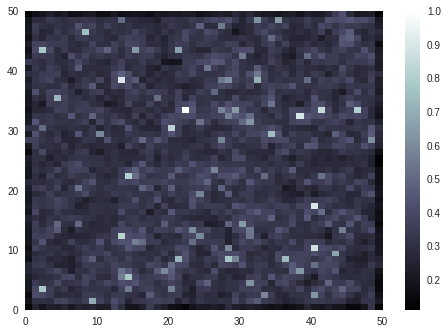

In [37]:
from pylab import plot,axis,show,pcolor,colorbar,bone
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()
# loading the labels
#target = genfromtxt('iris.csv',
#                    delimiter=',',usecols=(4),dtype=str)
#t = zeros(len(target),dtype=int)
#t[target == 'setosa'] = 0
#t[target == 'versicolor'] = 1
#t[target == 'virginica'] = 2
# use different colors and markers for each label
#markers = ['o','s','D']
#colors = ['r','g','b']
for cnt,xx in enumerate(MagR):
 w = som.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
 plot(w[0]+.5,w[1]+.5)#,markers[t[cnt]],markerfacecolor='None',
   #markeredgecolor=colors[t[cnt]],markersize=12,markeredgewidth=2)
#axis([0,som.weights.shape[0],0,som.weights.shape[1]])
show() # show the figure

# Algoritmo *k-means* de las características y visualización con PCA

In [0]:
from sklearn.cluster import KMeans

In [0]:
LC=[]
for i in range(len(Nombres)):
    LC.append([Periodo[i]]+MagR[i])

In [0]:
kmeans = KMeans(n_clusters=3,init='k-means++').fit(LC)
labels = kmeans.predict(LC)

In [44]:
import collections
collections.Counter(labels)

Counter({0: 28165, 1: 74, 2: 365})

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(LC) 
pca_2d = pca.transform(LC)

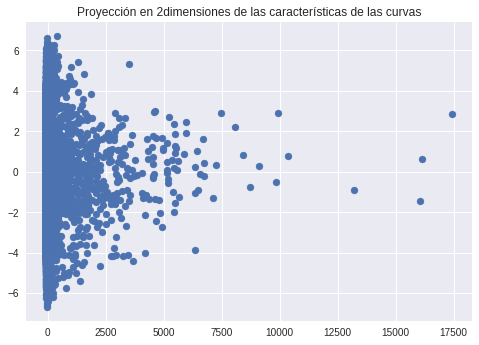

In [51]:
plt.scatter(pca_2d[:,0],pca_2d[:,1])
plt.title('Proyección en 2dimensiones de las características de las curvas')
plt.savefig('Proyecciones.eps',format='eps')

In [0]:
ind_0=[i for i in range(len(pca_2d)) if labels[i]==0]
ind_1=[i for i in range(len(pca_2d)) if labels[i]==1]
ind_2=[i for i in range(len(pca_2d)) if labels[i]==2]

c1=pca_2d[ind_0]
c2=pca_2d[ind_1]
c3=pca_2d[ind_2]


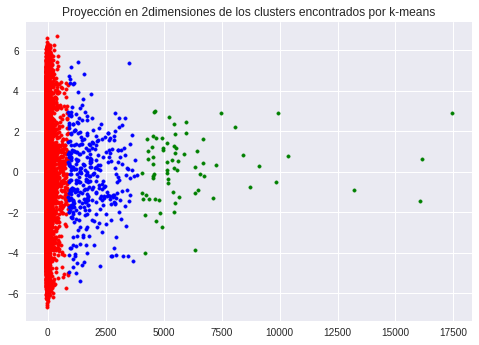

In [53]:
plt.scatter(c1[:,0],c1[:,1],c='r',marker='.')
plt.scatter(c2[:,0],c2[:,1],c='g',marker='.')
plt.scatter(c3[:,0],c3[:,1],c='b',marker='.')
plt.title('Proyección en 2dimensiones de los clusters encontrados por k-means')
plt.savefig('Proyecciones_clusters.eps',format='eps')

https://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-clusters-in-a-k-means-unsupervised-learning-model/